In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def show_tensor_images(image_flattened, num_images=25, size=(1, 28, 28)):
  image = image_flattened.detach().cpu().view(-1, *size) # 画像のサイズ1x28x28に戻す
  image_grid = make_grid(image[:num_images], nrow=5) # 画像を並べる
  plt.imshow(image_grid.permute(1, 2, 0).squeeze()) # 画像の表示
  plt.show()

In [3]:
class GeneratorBlock(nn.Module):
  def __init__(self, input_channels, output_channels, kernel_size=3, stride=2,
                    final_layer=False):
    super(GeneratorBlock, self).__init__()
    if not final_layer:
      self.generator_block = nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True))
    else:
      self.generator_block = nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels,
                             kernel_size, stride),
                             nn.Tanh())
  def forward(self, x):
    return self.generator_block(x)

In [4]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, image_dim=1, hidden_dim=128):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.generator = nn.Sequential(GeneratorBlock(z_dim, hidden_dim * 4),
                                   GeneratorBlock(hidden_dim * 4, hidden_dim * 2,
                                                  kernel_size=4, stride=1),
                                   GeneratorBlock(hidden_dim * 2, hidden_dim),
                                   GeneratorBlock(hidden_dim, image_dim,
                                                  kernel_size=4, final_layer=True))
  def forward(self, noise):
    noise_reshaped = noise.view(len(noise), self.z_dim, 1, 1)
    return self.generator(noise_reshaped)

  def get_generator(self):
    return self.generator

In [5]:
def get_noise(n_samples, z_dim, device='cuda'):
  return torch.randn(n_samples, z_dim, device=device)

In [6]:
class DiscriminatorBlock(nn.Module):
  def __init__(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    super(DiscriminatorBlock, self).__init__()
    if not final_layer:
      self.discriminator_block = nn.Sequential(nn.Conv2d(input_channels, output_channels,
                                                        kernel_size, stride),
                                              nn.BatchNorm2d(output_channels),
                                              nn.LeakyReLU(negative_slope=0.2,
                                                           inplace=True))
    else:
      self.discriminator_block = nn.Sequential(nn.Conv2d(input_channels, output_channels,
                                                         kernel_size, stride))
  def forward(self, x):
    return self.discriminator_block(x)

In [7]:
class Discriminator(nn.Module):
  def __init__(self, image_channels, hidden_channels):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(DiscriminatorBlock(image_channels, hidden_channels),
                                       DiscriminatorBlock(hidden_channles, hidden_channels * 2),
                                       DiscriminatorBlock(hidden_channels * 2, 1,
                                                          final_layer=True))
  def forward(self, input_images):
    prediction = self.discriminator(input_images)
    return prediction.view(len(prediction), -1)

In [8]:
z_dim = 100
batch_size = 128
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999
num_of_epochs = 50
device = 'cuda'

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 86951007.62it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80488833.11it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25331358.11it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3753798.77it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
image_channels = 1
hidden_channles = 16
# インスタンス化
generator = Generator(z_dim).to(device)
discriminator = Discriminator(image_channels=image_channels, hidden_channels=hidden_channles).to(device)

# オプティマイザ
gen_opt = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

In [11]:
# ウェイトの初期化
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

In [12]:
criterion = nn.BCEWithLogitsLoss()

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.635437250137329
Discriminator loss: 2.529608726501465


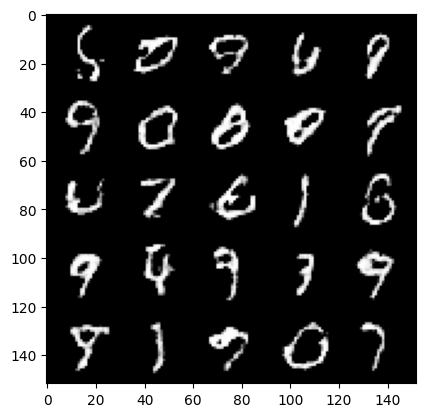

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.606675863265991
Discriminator loss: 2.5343782901763916


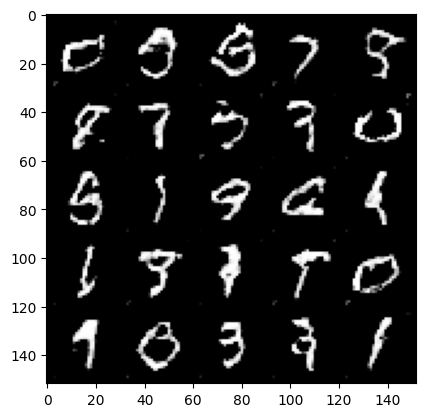

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.6097512245178223
Discriminator loss: 2.540426731109619


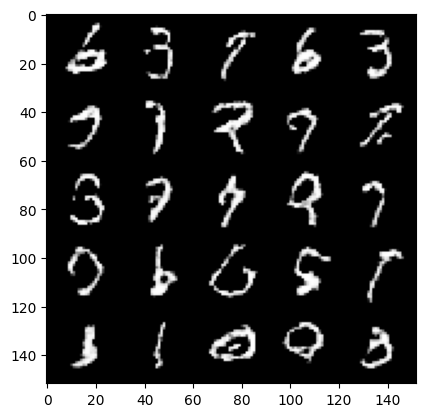

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.5898637771606445
Discriminator loss: 2.543476104736328


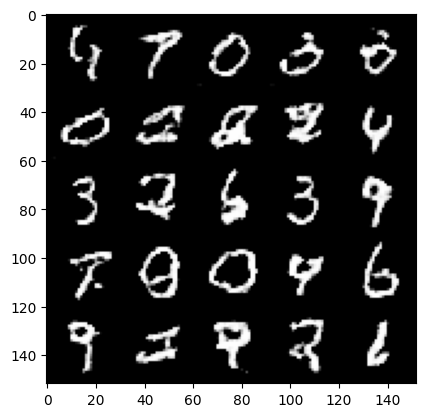

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.595057964324951
Discriminator loss: 2.5459766387939453


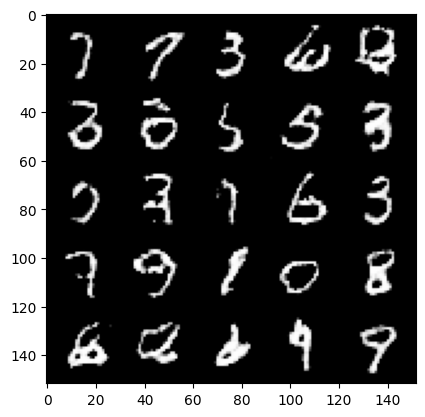

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.575974702835083
Discriminator loss: 2.5454635620117188


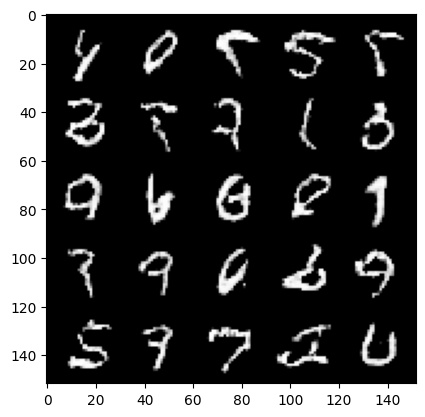

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.5758683681488037
Discriminator loss: 2.54672908782959


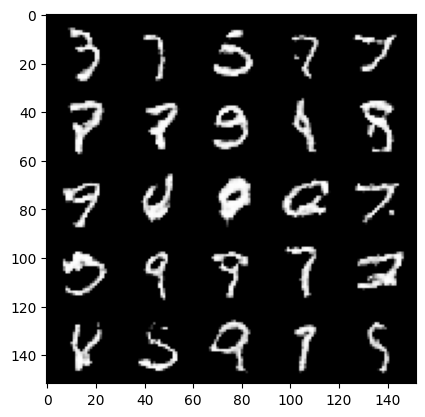

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.577096700668335
Discriminator loss: 2.5497848987579346


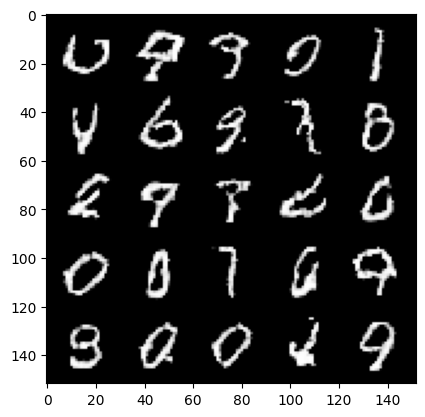

  0%|          | 0/469 [00:00<?, ?it/s]

Generator loss: 2.5707433223724365
Discriminator loss: 2.5495944023132324


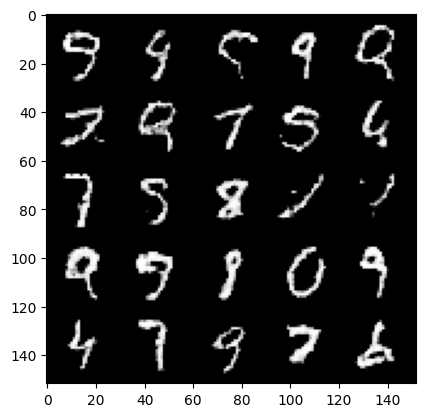

In [ ]:
for epoch in range(num_of_epochs):
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  for real_images, _ in tqdm(dataloader):
    real_images = real_images.to(device)

    # discriminator
    disc_opt.zero_grad() # 勾配の初期化
    # 偽画像
    noise = get_noise(len(real_images), z_dim, device=device) # ノイズの生成
    fake_images = generator(noise) # 偽画像を生成
    disc_fake_prediction = discriminator(fake_images.detach()) # Discriminatorで予測
    correct_labels = torch.zeros_like(disc_fake_prediction) # 偽画像の正解ラベルは0
    disc_fake_loss = criterion(disc_fake_prediction, correct_labels) # 偽画像に対する損失を計算

    # 本物の画像
    disc_real_prediction = discriminator(real_images) # Discriminatorで予測
    correct_labels = torch.ones_like(disc_real_prediction) # 本物の画像の正解ラベルは1
    disc_real_loss = criterion(disc_real_prediction, correct_labels) # 本物の画像に対する損失を計算

    # 最終的な損失
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    disc_loss.backward()
    disc_opt.step()

    # エポックごとの損失
    mean_discriminator_loss += disc_loss / len(real_images)

    # generator
    gen_opt.zero_grad() # 勾配の初期化
    fake_noise = get_noise(len(real_images), z_dim, device=device) # ノイズの生成
    fake_images = generator(fake_noise) # 偽画像の生成
    disc_fake_prediction = discriminator(fake_images) # Discriminatorで予測
    correct_labels = torch.ones_like(disc_fake_prediction) # 本物の正解ラベルは1
    gen_loss = criterion(disc_fake_prediction, correct_labels) # 損失を計算
    gen_loss.backward()
    gen_opt.step()
    # エポックごとの損失
    mean_generator_loss += gen_loss / len(real_images)
  print(f'Generator loss: {mean_generator_loss}')
  print(f'Discriminator loss: {mean_discriminator_loss}')

  # 生成される画像を表示
  noise = get_noise(len(real_images), z_dim, device=device)
  show_tensor_images(generator(noise))

In [15]:
correct_labels = torch.ones_like(disc_fake_prediction)
gen_loss = criterion(disc_fake_prediction, correct_labels)